# Analyzing Keyword Planner Recommendations
This notebook processes the raw exports from Keyword Planner with and without the "exclude adult ideas" filter to determine which recommended keywords Google believes are Adult. 

We use the files created from the previous notebook to create an independent assessment of adult keywords by analyzing the search results from all recommended keywords for majority self-described pornographic websites.

We aggregate these two assessments and determine the count and percentage of adult, pornographic, or neither adult or pornographic recommended keywords for each input keyword.

In [1]:
%matplotlib inline
import json
import glob as glob
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from tqdm import tqdm

In [2]:
# inputs
## determined from the previous notebook
fn_dict = '../data/intermediary/keywords-labelled-as-adult.json'

## Examples of raw exports from Keyword Planner
fn_keyword_planner_no_filter = '../data/input/raw-exports/black-girls-no-filter.csv'
fn_keyword_planner_filter = '../data/input/raw-exports/black-girls-filter.csv'

# outputs
fn_table = '../data/output/volume-of-adult-rec-keywords.csv'
fn_figure = '../data/output/volume-of-adult-rec-keywords.png'

In [3]:
# These are what we input into Keyword planner (without hyphens).
keyword_inputs = [
    'black-girls', 
    'latina-girls', 
    'asian-girls', 
    'white-girls', 
    'black-boys', 
    'latino-boys', 
    'asian-boys', 
    'white-boys'
]

In [4]:
# Which recommended keywords' search results were majority pornographic?
keyword2adult = json.load(open(fn_dict))
len(keyword2adult.keys())

1976

In [5]:
# Note this is an underestimation, as we only look for 132 pornographic websites.
porn_keywords = [k for k, v in keyword2adult.items() if v]
len(porn_keywords)

1549

In [6]:
# we create these columns
all_adult_cols = [
    'Google_Adult', 
    'SERP_Adult'
]

def keyword_to_df(keyword : str) -> pd.DataFrame:
    """
    Creates a dataframe that merges the filtered and unfiltered recommended keywords
    exported from Google Keyword Planner.
    """
    fn = f'../data/input/raw-exports/{keyword}-no-filter.csv'
    fn_filter = f'../data/input/raw-exports/{keyword}-filter.csv'
    
    df = pd.read_csv(fn, skiprows=[0,1], 
                     sep='\t', 
                     encoding='utf-16')
    dff = pd.read_csv(fn_filter, skiprows=[0,1], 
                      sep='\t', 
                      encoding='utf-16')
    
    # check which keywords Google's "Adult ideas" filter catches
    df.loc[:,'Google_Adult'] = ~df.Keyword.apply(lambda x: x in dff.Keyword.unique())

    # check which keywords' search results were majority pornographic?
    df.loc[:, "SERP_Adult"] = df.Keyword.isin(porn_keywords)
    
    # this is True if Google's filters or our dictionaries catches a keyword
    df['All_Adult'] = df.apply(lambda x: any(x[col] for col in all_adult_cols), axis=1)
    
    return df

In [7]:
def aggregate(df : pd.DataFrame) -> dict:
    """
    A count-based aggregator for the number of keywords for certain categorizations.
    """
    # counts
    n_keywords = len(df)
    n_keywords_not_adult = len(df[df.Google_Adult != True])
    n_google_adult = len(df[df.Google_Adult == True])
    n_serp_missing_adult = len(df[(df.SERP_Adult == True) & (df.Google_Adult != True)])
    n_serp_adult = len(df[(df.SERP_Adult == True)])
    n_all = len(df[df.All_Adult == True])

    try:
        row = {
            'n_keywords' : n_keywords,
            'n_google_adult' : n_google_adult,
            'n_serp_adult' : n_serp_adult,
            'n_serp_missing_adult' : n_serp_missing_adult,
            'n_all_adult' : n_all,
        }
    except:
        row = {
            'n_keywords' : 1,
            'n_google_adult' : 0,
            'n_serp_adult' : 0,
            'n_serp_missing_adult' : 0,
            'n_all_adult' : 0,
        }
        
    return row

In [8]:
keyword2stats = {}
for keyword in tqdm(keyword_inputs):
    fn_out = f'../data/intermediary/preprocessed/{keyword}-preprocessed.tsv'
    df = keyword_to_df(keyword)
    df.to_csv(fn_out, index=False, sep='\t')
    row = aggregate(df)
    keyword2stats[keyword.replace('-', ' ')] = row
    
results = pd.DataFrame(keyword2stats).T

100%|██████████| 8/8 [00:00<00:00, 10.55it/s]


In [9]:
def highlight_row(row : dict, col='index') -> list:
    """Alters row colors according to Race"""
    
    color = ['background-color: white']* len(row) 
    if 'black' in row[col].lower():
        color = ['background-color: #A54C77'] * len(row)
    elif 'latin' in row[col].lower():
        color = ['background-color: #F5B26A'] * len(row)
    elif 'asian' in row[col].lower():
        color = ['background-color: #92C47B'] * len(row)
    elif 'white' in row[col].lower():
        color = ['background-color: #9fc5e8'] * len(row)
    return color

In [10]:
results['label'] = results.reset_index().apply(lambda x : '"' + f"{x['index'].capitalize()}" + f'" ' + f"({x['n_keywords']})" , axis=1).tolist()

In [11]:
results['n_not_adult'] = results['n_keywords'] - results['n_google_adult'] - results['n_serp_missing_adult']
for col in ['n_google_adult', 'n_serp_missing_adult', 'n_not_adult']:
    col_out = col.replace('n_', '%_')
    results[col_out] = (results[col] / results['n_keywords']) * 100

In [12]:
display_cols = [
    'n_keywords', '%_google_adult', '%_serp_missing_adult', '%_not_adult'
]

In [13]:
results[display_cols].round(1).reset_index().style.apply(highlight_row, axis=1)

,index,n_keywords,%_google_adult,%_serp_missing_adult,%_not_adult
0,black girls,435,46.7,39.3,14
1,latina girls,582,58.8,29.2,12
2,asian girls,273,69.2,18.7,12.1
3,white girls,1,0,0,100
4,black boys,122,36.1,44.3,19.7
5,latino boys,180,32.8,55,12.2
6,asian boys,382,34.3,47.4,18.3
7,white boys,1,0,0,100


In [14]:
results.to_csv(fn_table)

## Bar Charts

In [15]:
label2color = {
    'What Google calls "Adult"' : '#ff335f',
    'Not "Adult", but we found to be pornographic*' : '#fbd7de',
    'Not Adult or pornographic' : '#e6f3ff',
}

In [16]:
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label,
                          markerfacecolor=c, markersize=10)
                   for label, c in label2color.items()][::-1]

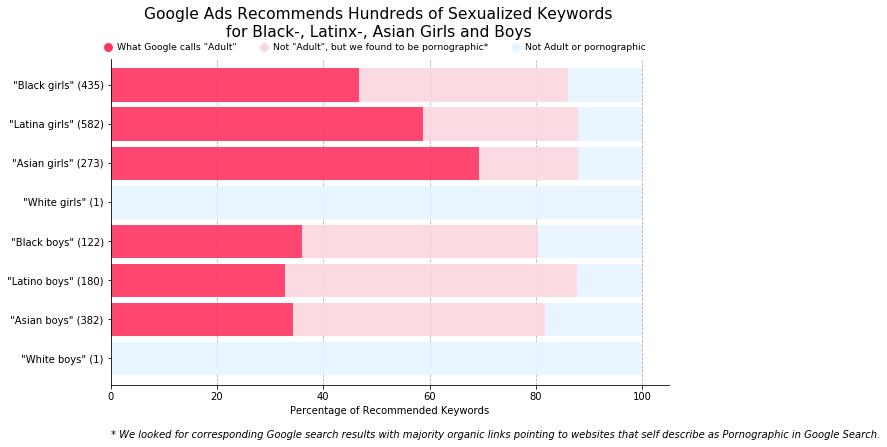

In [17]:
ax = results[::-1].plot(x='label', y=["%_google_adult", "%_serp_missing_adult", "%_not_adult"], 
                        kind="barh", stacked=True, 
                        width=.85, alpha=.9,
                        color=label2color.values(),
                        figsize=(10,6), legend=False)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

x_axis = ax.axes.get_yaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)

ax.legend(
    handles=legend_elements[::-1],
    loc='lower left', 
    bbox_to_anchor= (-0.025, 1.015), ncol=5,
    handletextpad=0.0,
    labelspacing=0, 
    borderaxespad=.1, 
    borderpad=0.1,
    frameon=False,
    prop={'size': 9.2}
)

ax.set_axisbelow(True)
ax.xaxis.grid(True, zorder=-2,  linestyle='--')
ax.set_xlabel('Percentage of Recommended Keywords')

plt.title("Google Ads Recommends Hundreds of Sexualized Keywords\nfor Black-, Latinx-, Asian Girls and Boys",
         x=0.48,
         y=1.05,
         size=15.5)

plt.annotate("* We looked for corresponding Google search results with majority organic links pointing to websites that self describe as Pornographic in Google Search." , 
             (0.00, 0), (0, -45), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             style='italic',
             va='top');

Text(0, -45, '* We looked for corresponding Google search results with majority organic links pointing to websites that\n  self-identify as Pornographic in Google Search.')

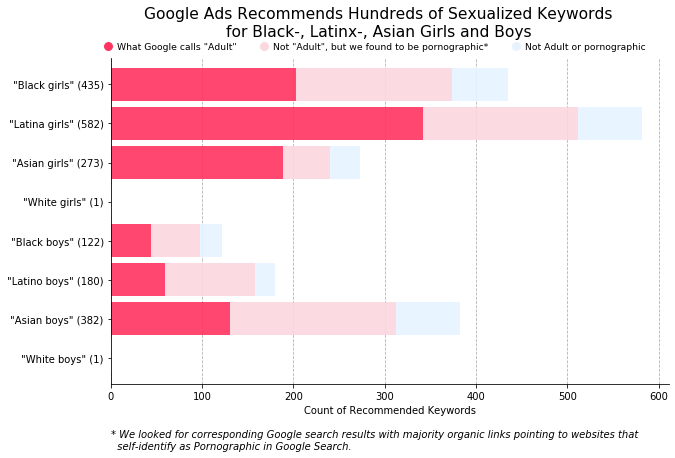

In [18]:
ax = results[::-1].plot(x='label', y=["n_google_adult", "n_serp_missing_adult", "n_not_adult"], 
                        kind="barh", stacked=True, 
                        width=.85, alpha=.9,
                        color=label2color.values(),
                        figsize=(10,6), legend=False)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

x_axis = ax.axes.get_yaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)

ax.legend(
    handles=legend_elements[::-1],
    loc='lower left', 
    bbox_to_anchor= (-0.025, 1.015), ncol=5,
    handletextpad=0.0,
    labelspacing=0, 
    borderaxespad=.1, 
    borderpad=0.1,
    frameon=False,
    prop={'size': 9.2}
)

ax.set_axisbelow(True)
ax.xaxis.grid(True, zorder=-2,  linestyle='--')

ax.set_xlabel('Count of Recommended Keywords')


plt.title("Google Ads Recommends Hundreds of Sexualized Keywords\nfor Black-, Latinx-, Asian Girls and Boys",
         x=0.48,
         y=1.05,
         size=15.5)


plt.annotate("* We looked for corresponding Google search results with majority organic links pointing to websites that\n  self-identify as Pornographic in Google Search." , 
             (0.00, 0), (0, -45), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             style='italic',
             va='top')

plt.savefig(fn_figure);